In [51]:
#Import Necessary Libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from imblearn.over_sampling import SMOTE

Received an error message so I looked up the error and found that I needed to [change the encodings](https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas)

In [52]:
#Import Data
df = pd.read_csv('https://raw.githubusercontent.com/josh-g-grimes/Twitter-Sentiment-NLP/main/data.csv', encoding='latin-1')

In [53]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [54]:
df = df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "tweet_sentiment"})

In [55]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,tweet_sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


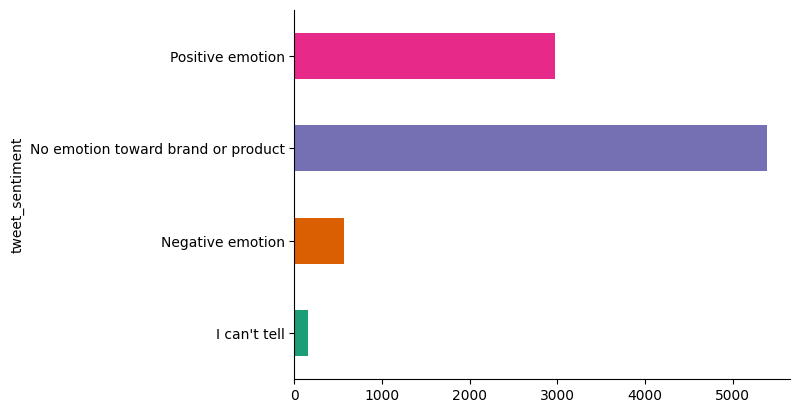

In [56]:
#Look at the distribution of emotions that are directed at brands or products
df.groupby('tweet_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [57]:
df.drop(columns=['emotion_in_tweet_is_directed_at'], inplace=True)

In [58]:
df['tweet_sentiment'] = df['tweet_sentiment'].map({'Positive emotion': 0, 'Negative emotion': 1})

In [59]:
df = df.dropna()

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3548 entries, 0 to 9088
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_text       3548 non-null   object 
 1   tweet_sentiment  3548 non-null   float64
dtypes: float64(1), object(1)
memory usage: 83.2+ KB


In [61]:
df['tweet_sentiment'].value_counts()

,count
tweet_sentiment,
0.0,2978
1.0,570


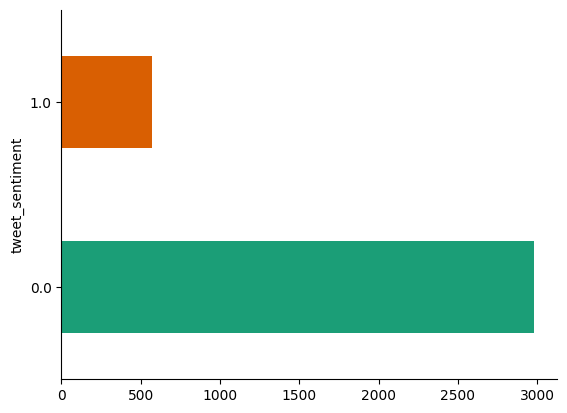

In [62]:
df.groupby('tweet_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [63]:
X = df['tweet_text']
y = df['tweet_sentiment']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
X_train = pd.concat([X_train, y_train.rename('Label')], axis=1)

In [66]:
X_train.head()

,tweet_text,Label
2802,What a great blog on the latest news of #SXSW ...,0.0
440,Lovin the digital! @mention band sings into iP...,0.0
1314,At #sxsw? We're giving away an iPad 2 to the c...,0.0
6226,RT @mention Just won an iPad 2 at #sxsw thanks...,0.0
5273,RT @mention #sxsw #geogames #android if you de...,0.0


In [67]:
X_train['tweet_text'] = X_train['tweet_text'].str.lower()

In [68]:
X_train.head()

,tweet_text,Label
2802,what a great blog on the latest news of #sxsw ...,0.0
440,lovin the digital! @mention band sings into ip...,0.0
1314,at #sxsw? we're giving away an ipad 2 to the c...,0.0
6226,rt @mention just won an ipad 2 at #sxsw thanks...,0.0
5273,rt @mention #sxsw #geogames #android if you de...,0.0


In [69]:
token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(token_pattern)



In [70]:
X_train["tweet_text_tokenized"] = X_train['tweet_text'].apply(tokenizer.tokenize)

In [71]:
X_train.head()

,tweet_text,Label,tweet_text_tokenized
2802,what a great blog on the latest news of #sxsw ...,0.0,"[what, great, blog, on, the, latest, news, of,..."
440,lovin the digital! @mention band sings into ip...,0.0,"[lovin, the, digital, mention, band, sings, in..."
1314,at #sxsw? we're giving away an ipad 2 to the c...,0.0,"[at, sxsw, we, re, giving, away, an, ipad, to,..."
6226,rt @mention just won an ipad 2 at #sxsw thanks...,0.0,"[rt, mention, just, won, an, ipad, at, sxsw, t..."
5273,rt @mention #sxsw #geogames #android if you de...,0.0,"[rt, mention, sxsw, geogames, android, if, you..."


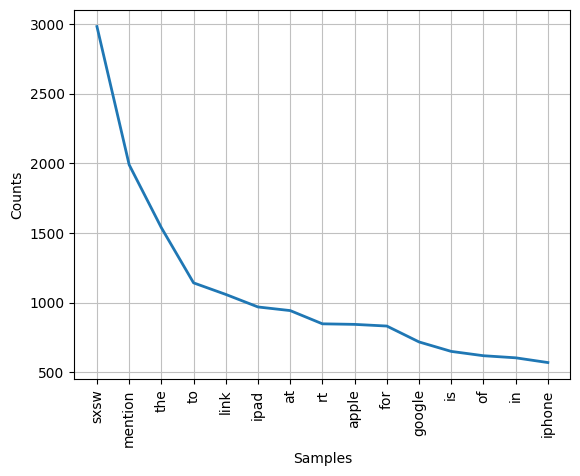

<Axes: xlabel='Samples', ylabel='Counts'>

In [72]:
train_freq_dist = FreqDist(X_train['tweet_text_tokenized'].sum())
train_freq_dist.plot(15, cumulative=False)

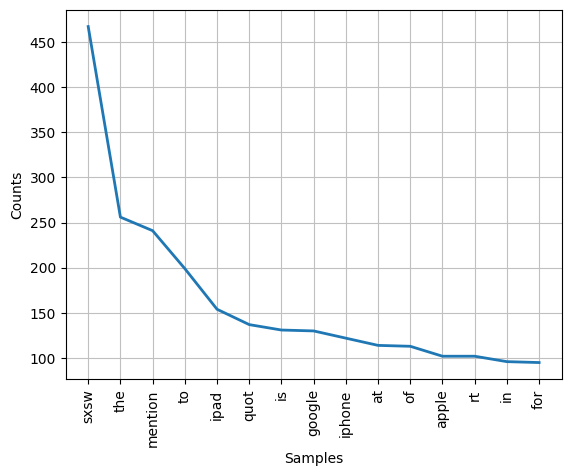

<Axes: xlabel='Samples', ylabel='Counts'>

In [73]:
train_freq_dist_negative = FreqDist(X_train[X_train['Label'] == 1]['tweet_text_tokenized'].sum())
train_freq_dist_negative.plot(15, cumulative=False)

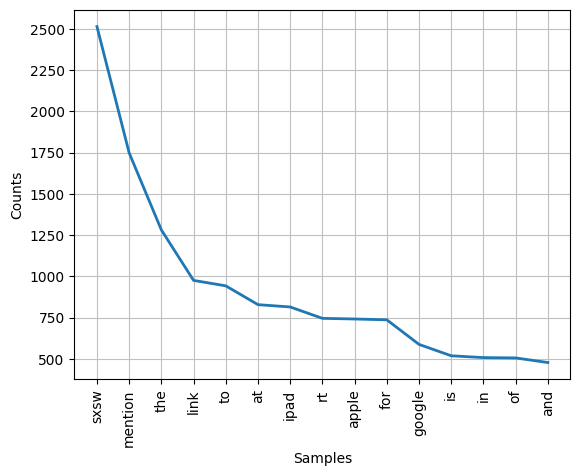

<Axes: xlabel='Samples', ylabel='Counts'>

In [74]:
train_freq_dist_positive = FreqDist(X_train[X_train['Label'] == 0]['tweet_text_tokenized'].sum())
train_freq_dist_positive.plot(15, cumulative=False)

In [75]:
tfidf = TfidfVectorizer(max_features=15)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

,apple,at,for,google,in,ipad,iphone,is,link,mention,of,rt,sxsw,the,to
0,0.310778,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.270072,0.226488,0.712965,0.000000,0.134781,0.502689,0.000000
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.694849,0.000000,0.000000,0.447235,0.000000,0.000000,0.266147,0.496318,0.000000
2,0.000000,0.366701,0.00000,0.000000,0.000000,0.354914,0.000000,0.000000,0.000000,0.000000,0.443256,0.000000,0.167589,0.625051,0.352582
3,0.000000,0.390964,0.00000,0.000000,0.000000,0.378397,0.000000,0.000000,0.000000,0.600503,0.000000,0.412460,0.178678,0.000000,0.375911
4,0.000000,0.000000,0.45809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329314,0.518327,0.452383,0.195973,0.000000,0.412296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0.454828,0.000000,0.00000,0.000000,0.000000,0.417738,0.000000,0.000000,0.000000,0.000000,0.521717,0.000000,0.197254,0.367846,0.414993
2834,0.000000,0.000000,0.00000,0.000000,0.000000,0.334687,0.000000,0.403917,0.316674,0.265569,0.000000,0.000000,0.158038,0.294714,0.664976
2835,0.000000,0.457041,0.00000,0.000000,0.000000,0.000000,0.545329,0.000000,0.418542,0.350997,0.000000,0.000000,0.208876,0.389518,0.000000
2836,0.000000,0.000000,0.00000,0.540649,0.584179,0.000000,0.000000,0.563724,0.000000,0.000000,0.000000,0.000000,0.220565,0.000000,0.000000


In [76]:
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.83978873, 0.83978873, 0.83978873, 0.83950617, 0.83950617])

In [77]:
y_train.value_counts(normalize=True)

,proportion
tweet_sentiment,
0.0,0.839676
1.0,0.160324


In [78]:
stopwords_list = stopwords.words('english')

In [79]:
def remove_stopwords(text):
    return [word for word in text if word not in stopwords_list]

In [80]:
X_train["tweet_text_no_stopwords"] = X_train["tweet_text_tokenized"].apply(remove_stopwords)

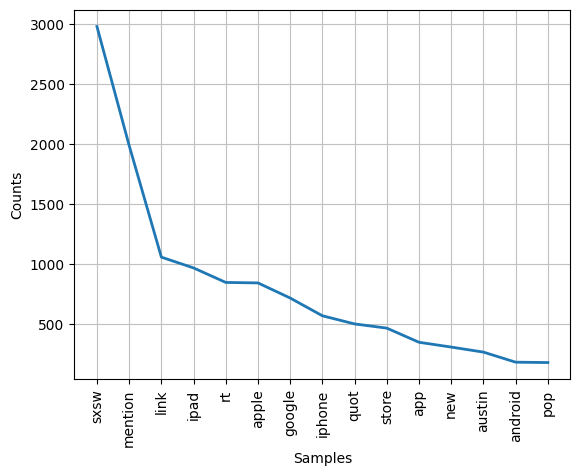

<Axes: xlabel='Samples', ylabel='Counts'>

In [81]:
train_freq_dist = FreqDist(X_train['tweet_text_no_stopwords'].sum())
train_freq_dist.plot(15, cumulative=False)

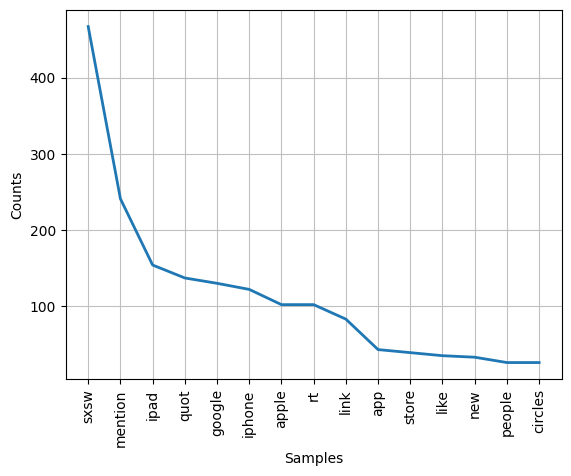

<Axes: xlabel='Samples', ylabel='Counts'>

In [82]:
train_freq_dist_negative = FreqDist(X_train[X_train['Label'] == 1]['tweet_text_no_stopwords'].sum())
train_freq_dist_negative.plot(15, cumulative=False)

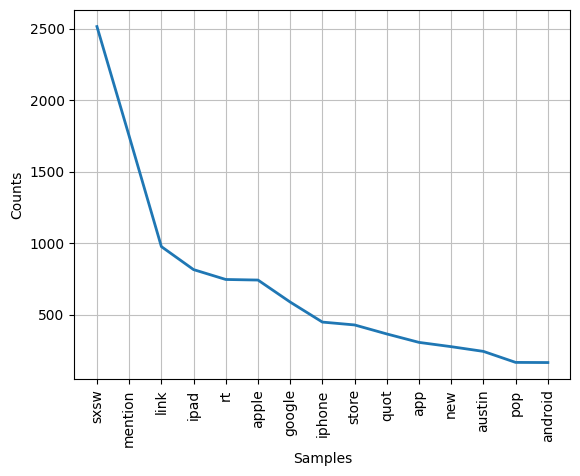

<Axes: xlabel='Samples', ylabel='Counts'>

In [83]:
train_freq_dist_positive = FreqDist(X_train[X_train['Label'] == 0]['tweet_text_no_stopwords'].sum())
train_freq_dist_positive.plot(15, cumulative=False)

In [84]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=15,
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

,android,app,apple,austin,google,ipad,iphone,link,mention,new,pop,quot,rt,store,sxsw
0,0.0000,0.000000,0.501279,0.000000,0.000000,0.000000,0.000000,0.435622,0.365320,0.0,0.0,0.0,0.000000,0.615006,0.217400
1,0.0000,0.696037,0.000000,0.000000,0.000000,0.000000,0.574683,0.000000,0.369891,0.0,0.0,0.0,0.000000,0.000000,0.220120
2,0.0000,0.000000,0.000000,0.000000,0.000000,0.904258,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.426987
3,0.0000,0.000000,0.000000,0.000000,0.000000,0.450397,0.000000,0.000000,0.714764,0.0,0.0,0.0,0.490941,0.000000,0.212676
4,0.7815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346548,0.0,0.0,0.0,0.476058,0.000000,0.206229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0.0000,0.000000,0.487625,0.718971,0.000000,0.447861,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.211478
2834,0.0000,0.000000,0.000000,0.000000,0.000000,0.603260,0.000000,0.570792,0.478676,0.0,0.0,0.0,0.000000,0.000000,0.284857
2835,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.681986,0.523428,0.438956,0.0,0.0,0.0,0.000000,0.000000,0.261220
2836,0.0000,0.000000,0.000000,0.000000,0.925912,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.377739


In [85]:
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stopwords_removed_cv

array([0.83978873, 0.83978873, 0.83978873, 0.83950617, 0.83950617])

In [86]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.8396757085724224
Stopwords removed: 0.8396757085724224


In [87]:
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [88]:

print("Original sample:", X_train.iloc[100]["tweet_text_tokenized"])
print("Stemmed sample: ", stem_and_tokenize(X_train.iloc[100]["tweet_text"]))

Original sample: ['google', 'amp', 'bavc', 'launch', 'impact', 'dashboard', 'at', 'sxsw', 'web', 'app', 'to', 'collect', 'host', 'and', 'visualize', 'data', 'in', 'real', 'time', 'bavc', 'org', 'impact']
Stemmed sample:  ['googl', 'amp', 'bavc', 'launch', 'impact', 'dashboard', 'at', 'sxsw', 'web', 'app', 'to', 'collect', 'host', 'and', 'visual', 'data', 'in', 'real', 'time', 'bavc', 'org', 'impact']


In [89]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [90]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=15,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,app,appl,austin,get,googl,ipad,iphon,link,mention,new,pop,quot,rt,store,sxsw
0,0.000000,0.502010,0.000000,0.0,0.000000,0.000000,0.000000,0.435667,0.365908,0.0,0.0,0.0,0.000000,0.613871,0.217840
1,0.671461,0.000000,0.000000,0.0,0.000000,0.000000,0.592608,0.000000,0.382301,0.0,0.0,0.0,0.000000,0.000000,0.227599
2,0.000000,0.000000,0.000000,0.0,0.000000,0.902324,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.431059
3,0.000000,0.000000,0.000000,0.0,0.000000,0.446325,0.000000,0.000000,0.716293,0.0,0.0,0.0,0.492195,0.000000,0.213219
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.555291,0.0,0.0,0.0,0.763127,0.000000,0.330587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0.000000,0.488544,0.720732,0.0,0.000000,0.443766,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.211996
2834,0.000000,0.000000,0.000000,0.0,0.000000,0.599228,0.000000,0.572512,0.480841,0.0,0.0,0.0,0.000000,0.000000,0.286264
2835,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.681414,0.523397,0.439591,0.0,0.0,0.0,0.000000,0.000000,0.261706
2836,0.000000,0.000000,0.000000,0.0,0.925831,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.377937


In [91]:
stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stemmed_cv

array([0.83978873, 0.83978873, 0.83978873, 0.83950617, 0.83950617])

In [92]:
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Stopwords removed: 0.8396757085724224
Stemmed:           0.8396757085724224


In [93]:
len(X_train)

2838

In [94]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=150,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,also,amp,android,app,appl,around,austin,away,awesom,back,...,way,week,win,work,world,would,wow,year,yes,ûï
0,0.0,0.000000,0.000000,0.000000,0.235318,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.255210,0.000000,0.198385,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.441132,0.000000,0.000000,0.000000,0.0,0.000000,0.626735,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.280898,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0.0,0.000000,0.000000,0.000000,0.324462,0.0,0.478668,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2834,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.581669,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2835,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
increased_features_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
increased_features_cv

array([0.83978873, 0.83978873, 0.83978873, 0.83950617, 0.83950617])

In [96]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),
    norm='l2',
    max_features=500,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,10,2011,40,6th,action,ad,alreadi,also,amaz,america,...,wonder,work,world,would,wow,year,yes,yet,ûï,ûï mention
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
max_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
max_cv

array([0.84859155, 0.85915493, 0.84507042, 0.85714286, 0.85008818])

In [102]:
print('Original class distribution: \n')
print(y_train.value_counts())

Original class distribution: 

tweet_sentiment
0.0    2383
1.0     455
Name: count, dtype: int64


In [112]:
smote = SMOTE(sampling_strategy = .382)
X_train_vectorized_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)
print('Synthetic Sample Class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Synthetic Sample Class distribution: 

tweet_sentiment
0.0    2383
1.0     910
Name: count, dtype: int64


In [113]:
max_cv_resampled = cross_val_score(baseline_model, X_train_vectorized_resampled, y_train_resampled)
max_cv_resampled

array([0.77693475, 0.7814871 , 0.80121396, 0.78571429, 0.7993921 ])